In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import seaborn as sns

In [22]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\4503933\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\4503933\AppData\Roaming\nltk_data...


------------------------------------------------------------


[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# # Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\4503933\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
df = pd.read_excel("SAIL_Goods - Copy.xlsx")

In [8]:
df.head()

,Tender Title,Label,Tender No and date,Plant/Unit,Tender issue date and time,Bid Submission Closing date and Time,Remarks,Label_Code
0,Procurement of water treatment chemicals for 4...,raw_materials,000000001738 Dt. 17/01/2020,IISCO Steel Plant,Feb 18 2020 5:00:00:000PM,Mar 25 2020 12:00:00:000PM,Corr,4
1,SPARES FOR ROD MILL LINER,hardware,003/215/1902000911/500006763/01/00,Rourkela Steel Plant,Jan 8 2020 8:00:00:000PM,May 21 2020 4:00:00:000PM,Corr,2
2,"SPARES FOR OVEN INTERLOCKING SYSTEM OF COB-1,3...",hardware,003/340/1902000406/01/00/500006867 dated 21.01...,Rourkela Steel Plant,Feb 26 2020 7:00:00:000PM,Mar 26 2020 4:00:00:000PM,Corr,2
3,ORIFICE FLOW METER FOR RAW WATER RISING MAIN,hardware,003/530/1902002486/01/00/500006927 DTD.20.02.2020,Rourkela Steel Plant,Feb 20 2020 8:00:00:000PM,Apr 20 2020 4:00:00:000PM,Corr,2
4,Manganese metal Briquette,raw_materials,007/619/1960000044/02/00/500006985 DATED:18.03...,Rourkela Steel Plant,Mar 18 2020 7:00:00:000PM,May 26 2020 4:00:00:000PM,Corr,4


In [9]:
df.shape

(294, 8)

In [10]:
df.Label.value_counts()

raw_materials               88
none                        60
hardware                    46
vehicle/equipment_hiring    42
machine                     35
electronics                 23
Name: Label, dtype: int64

In [11]:
df.isnull().sum()

Tender Title                            2
Label                                   0
Tender No and date                      0
Plant/Unit                              0
Tender issue date and time              0
Bid Submission Closing date and Time    0
Remarks                                 1
Label_Code                              0
dtype: int64

In [12]:
df = df[pd.notnull(df['Tender Title'])]

In [13]:
df.isnull().sum()

Tender Title                            0
Label                                   0
Tender No and date                      0
Plant/Unit                              0
Tender issue date and time              0
Bid Submission Closing date and Time    0
Remarks                                 1
Label_Code                              0
dtype: int64

In [14]:
df.shape

(292, 8)

In [16]:
# \r and \n
df['Content_Parsed_1'] = df['Tender Title'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")

In [17]:
# " when quoting text
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')

In [18]:
# Lowercasing the text
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()

In [19]:
punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']

for punct_sign in punctuation_signs:
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')

In [20]:
df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")

In [21]:
df['Content_Parsed_4']

0      procurement of water treatment chemicals for 4...
1                              spares for rod mill liner
2      spares for oven interlocking system of cob-135...
3          orifice  flow meter for raw water rising main
4                              manganese metal briquette
                             ...                        
289    hiring of 02 (two) no diesel operated mahindra...
290    hiring of 03 (three) no diesel operated mahind...
291    hiring of 02 (two) no diesel operated mahindra...
292    smoke based mosquito control for adult mosquit...
293                                 allotment of canteen
Name: Content_Parsed_4, Length: 292, dtype: object

In [23]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [24]:
df.iloc[100]

Tender Title                            FA No. 24003027 dt. 13.05.20 – IDLE ASSETS –Co...
Label                                                                         electronics
Tender No and date                      FA No. 24003027 dt. 13.05.20 – IDLE ASSETS –Co...
Plant/Unit                                                             Bokaro Steel Plant
Tender issue date and time                                     May  8 2020  1:05:00:000PM
Bid Submission Closing date and Time                           May 13 2020  6:00:00:000PM
Remarks                                                                              --  
Label_Code                                                                              1
Content_Parsed_1                        FA No. 24003027 dt. 13.05.20 – IDLE ASSETS –Co...
Content_Parsed_2                        fa no. 24003027 dt. 13.05.20 – idle assets –co...
Content_Parsed_3                        fa no 24003027 dt 130520 – idle assets –coke o...
Content_Pa

In [25]:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    #print (row)
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.iloc[row]['Content_Parsed_4']
    text_words = str(text).split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [26]:
df['Content_Parsed_5'] = lemmatized_text_list

In [28]:
# Loading the stop words in english
stop_words = list(stopwords.words('english'))

In [29]:
df['Content_Parsed_6'] = df['Content_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')

In [30]:
list_columns = ["Label",  "Tender Title", "Content_Parsed_6", "Label_Code"]
df = df[list_columns]

df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})

In [31]:
df.head()

,Label,Tender Title,Content_Parsed,Label_Code
0,raw_materials,Procurement of water treatment chemicals for 4...,procurement water treatment chemicals 4161 m...,4
1,hardware,SPARES FOR ROD MILL LINER,spar rod mill liner,2
2,hardware,"SPARES FOR OVEN INTERLOCKING SYSTEM OF COB-1,3...",spar oven interlock system cob-135 6,2
3,hardware,ORIFICE FLOW METER FOR RAW WATER RISING MAIN,orifice flow meter raw water rise main,2
4,raw_materials,Manganese metal Briquette,manganese metal briquette,4


In [32]:
df.Label_Code.value_counts()

4    88
6    58
2    46
5    42
3    35
1    23
Name: Label_Code, dtype: int64

In [39]:
category_codes = {
    'electronics': 1,
    'hardware': 2,
    'machine': 3,
    'raw_materials': 4,
    'vehicle/equipment_hiring': 5,
    'none' : 6    
}

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'], 
                                                    df['Label_Code'], 
                                                    test_size=0.3, 
                                                    random_state=8)

We have to define the different parameters:

* `ngram_range`: We want to consider both unigrams and bigrams.
* `max_df`: When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold
* `min_df`: When building the vocabulary ignore terms that have a document
    frequency strictly lower than the given threshold.
* `max_features`: If not None, build a vocabulary that only consider the top
    max_features ordered by term frequency across the corpus.

See `TfidfVectorizer?` for further detail.

In [36]:
# Parameter election
ngram_range = (1,3)
min_df = 10
max_df = 1.
max_features = 500

In [37]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(204, 26)
(88, 26)


In [40]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
#     print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[3:])))
    print("")

# 'electronics' category:
  . Most correlated unigrams:
. job
. dt
. supply
. commission
. installation
  . Most correlated bigrams:
. steel plant
. supply installation

# 'hardware' category:
  . Most correlated unigrams:
. tender
. mt
. fa
. hire
. job
  . Most correlated bigrams:
. olfa sale
. steel plant

# 'machine' category:
  . Most correlated unigrams:
. job
. sail
. supply
. installation
. commission
  . Most correlated bigrams:
. steel plant
. supply installation

# 'none' category:
  . Most correlated unigrams:
. steel
. procurement
. plant
. contract
. job
  . Most correlated bigrams:
. olfa sale
. steel plant

# 'raw_materials' category:
  . Most correlated unigrams:
. fa
. coal
. olfa
. chemicals
. mt
  . Most correlated bigrams:
. coal chemicals
. olfa sale

# 'vehicle/equipment_hiring' category:
  . Most correlated unigrams:
. sale
. job
. basis
. mine
. hire
  . Most correlated bigrams:
. supply installation
. olfa sale



In [41]:
bigrams

['steel plant', 'coal chemicals', 'supply installation', 'olfa sale']

In [43]:
print(features_train.shape)
print(features_test.shape)

(204, 26)
(88, 26)


In [44]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


In [45]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [46]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [47]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.5343137254901961


In [48]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sampl...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=8,
                                  

In [49]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.5


In [50]:
best_rfc = grid_search.best_estimator_

In [51]:
best_rfc

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [52]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [53]:
rfc_pred = best_rfc.predict(features_test)

In [54]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
0.6225490196078431


In [55]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.5681818181818182


In [57]:
# # Test accuracy
# from sklearn.metrics import roc_auc_score
# print("The test roc is: ")
# print(roc_auc_score(labels_test, rfc_pred))

In [58]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.23      0.50      0.32        14
           3       1.00      0.25      0.40         8
           4       0.69      0.80      0.74        25
           5       0.91      0.67      0.77        15
           6       0.69      0.58      0.63        19

    accuracy                           0.57        88
   macro avg       0.59      0.47      0.48        88
weighted avg       0.63      0.57      0.56        88



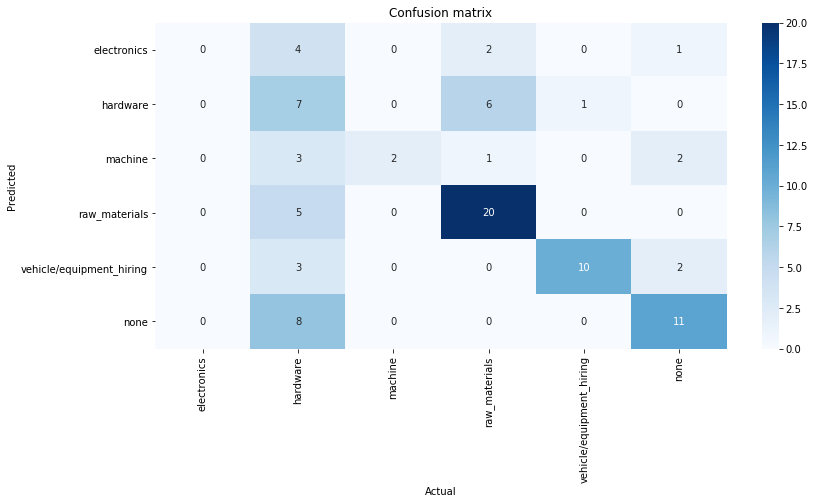

In [61]:
aux_df = df[['Label', 'Label_Code']].drop_duplicates().sort_values('Label_Code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Label'].values, 
            yticklabels=aux_df['Label'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [62]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.5568181818181818

In [63]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

0.5681818181818182

In [64]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])

In [65]:
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.622549,0.568182


In [66]:
category_names = {
    1: 'electronics',
    2: 'hardware',
    3: 'machine',
    4: 'raw_materials',
    5: 'vehicle/equipment_hiring',
    6: 'none'
}

In [67]:
predictions = best_rfc.predict(features_test)

In [68]:
# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions
df_test['Prediction'] = predictions

# Clean columns
df_test = df_test[['Tender Title', 'Label', 'Label_Code', 'Prediction']]

# Decode
df_test['Label_Predicted'] = df_test['Prediction']
df_test = df_test.replace({'Label_Predicted':category_names})

# Clean columns again
df_test = df_test[['Tender Title', 'Label', 'Label_Predicted']]

In [69]:
df_test.head()

,Tender Title,Label,Label_Predicted
116,Procurement of Wooden Liner,raw_materials,raw_materials
78,Blood Chemistry Analyzer,electronics,hardware
292,Smoke based mosquito control for adult mosquit...,vehicle/equipment_hiring,hardware
175,Global Tender for 1414 MT of Silicon Carbide-8...,raw_materials,raw_materials
176,Global Tender for 110 MT of Carbon Blackfor SR...,raw_materials,raw_materials


In [70]:
df_test.shape

(88, 3)

In [71]:
df_test.to_csv("results_sail_goods.csv", index = False)

In [72]:
condition = (df_test['Label'] != df_test['Label_Predicted'])

df_misclassified = df_test[condition]

df_misclassified.head(3)

,Tender Title,Label,Label_Predicted
78,Blood Chemistry Analyzer,electronics,hardware
292,Smoke based mosquito control for adult mosquit...,vehicle/equipment_hiring,hardware
55,Open Tender for Procurement of 3 core x 70 sq....,hardware,raw_materials


Feature engineering workflow

In [73]:
punctuation_signs = list("?:!.,;")
stop_words = list(stopwords.words('english'))

def create_features_from_text(text):
    
    # Dataframe creation
    lemmatized_text_list = []
    df = pd.DataFrame(columns=['Content'])
    df.loc[0] = text
    df['Content_Parsed_1'] = df['Content'].str.replace("\r", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')
    df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()
    df['Content_Parsed_3'] = df['Content_Parsed_2']
    for punct_sign in punctuation_signs:
        df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')
    df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_list = []
    text = df.loc[0]['Content_Parsed_4']
    text_words = text.split(" ")
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_list)    
    lemmatized_text_list.append(lemmatized_text)
    df['Content_Parsed_5'] = lemmatized_text_list
    df['Content_Parsed_6'] = df['Content_Parsed_5']
    for stop_word in stop_words:
        regex_stopword = r"\b" + stop_word + r"\b"
        df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')
    df = df['Content_Parsed_6']
#     df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})
    
    # TF-IDF
    features = tfidf.transform(df).toarray()
    
    return features

In [74]:
def get_category_name(category_id):
    for category, id_ in category_codes.items():    
        if id_ == category_id:
            return category

In [79]:
def predict_from_text(text):
    
    # Predict using the input model
    prediction_mnb = best_rfc.predict(create_features_from_text(text))[0]
    
    # Return result
    category_mnb = get_category_name(prediction_mnb)
    
#     print("The predicted category using the MNB model is %s." %(category_mnb) )
    return (category_mnb)

In [80]:
def predict_from_text_prob(text):
    
    # Predict using the input model
    prediction_mnb_proba = best_rfc.predict_proba(create_features_from_text(text))[0]
    
    
#     print("The conditional probability is: %a" %(prediction_mnb_proba.max()*100))
    return (prediction_mnb_proba.max()*100)

In [81]:
text = """

OLFA FOR SALE OF INDUSTRIAL GASES (LIQUID ARGON)

"""

In [82]:
predict_from_text(text)

'raw_materials'

In [83]:
predict_from_text_prob(text)

94.41993583591488

In [ ]:
a["predicted_class"] = b.apply(lambda row : predict_from_text(row["Values"]), axis = 1) 
a["predicted_class_prob"] = b.apply(lambda row : predict_from_text_prob(row["Values"]), axis = 1) 